## Purpose
This notebook will take RA-related SNPs obtained from the EBI GWAS catalog (https://www.ebi.ac.uk/gwas/docs/file-downloads; accessed 6/28/2020).

#### Process:
1. Import the EBI data and filter to obtain RA SNPs
2. Combine the list of SNP ids and filter to obtain unique SNPs.
3. Use the SNP id's to obtain all SNPs in linkage disequilibrium (LD) with GWAS SNPs

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import requests
from requests_futures.sessions import FuturesSession
from concurrent.futures import as_completed
import time
import json
import re

In [2]:
%cd ../data/snp_data

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


### Get the EBI GWAS SNPs

In [3]:
ra = pd.read_table("source_snps/EBI_GWAS_v1.tab", low_memory=False)

In [4]:
ra.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV'],
      dtype='object')

In [5]:
disease_all = ra['DISEASE/TRAIT'].unique().tolist()


In [6]:
ra_terms = [x for x in disease_all if 'Rheumatoid arthritis' in x]
ra_terms 

['Rheumatoid arthritis',
 'Celiac disease or Rheumatoid arthritis',
 'Rheumatoid arthritis (ACPA-negative)',
 'Celiac disease and Rheumatoid arthritis',
 'Rheumatoid arthritis (ACPA-positive)',
 'Rheumatoid arthritis (rheumatoid factor and/or anti-cyclic citrullinated peptide seropositive)']

In [7]:
ebi_ra = ra[[x in ra_terms for x in ra['DISEASE/TRAIT']]]
ebi_ra

,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,P-VALUE,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV
235,2008-08-11,18668548,Julia A,2008-08-01,Arthritis Rheum,www.ncbi.nlm.nih.gov/pubmed/18668548,Genome-wide association study of rheumatoid ar...,Rheumatoid arthritis,"400 European ancestry cases, 400 European ance...","410 European ancestry cases, 394 European ance...",...,intergenic_variant,1.0,NR,1E-9,9.000000,NaN,NaN,NaN,Illumina [299918],N
236,2008-08-11,18668548,Julia A,2008-08-01,Arthritis Rheum,www.ncbi.nlm.nih.gov/pubmed/18668548,Genome-wide association study of rheumatoid ar...,Rheumatoid arthritis,"400 European ancestry cases, 400 European ance...","410 European ancestry cases, 394 European ance...",...,intergenic_variant,1.0,0.49,6E-6,5.221849,NaN,1.61,[NR],Illumina [299918],N
2680,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.67,1E-7,7.000000,NaN,1.12,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2681,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.24,4E-6,5.397940,NaN,1.11,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2682,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.75,8E-9,8.096910,NaN,1.15,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2683,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intergenic_variant,1.0,0.10,6E-42,41.221849,NaN,1.79,[1.65-1.94],"Affymetrix, Illumina [at least 315971] (imputed)",N
2684,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intergenic_variant,1.0,0.50,4E-186,185.397940,NaN,2.55,[2.40-2.71],"Affymetrix, Illumina [at least 315971] (imputed)",N
2685,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.22,2E-9,8.698970,NaN,1.24,[1.16-1.32],"Affymetrix, Illumina [at least 315971] (imputed)",N
2686,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,non_coding_transcript_exon_variant,0.0,0.20,4E-6,5.397940,NaN,1.14,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2687,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.34,3E-8,7.52

Revathy: Data corresponding to RA related terms = 746

In [8]:
len(ebi_ra.SNPS.unique())

341

Number of unique SNPs associated with Rheumatoid arthritis = 341

In [9]:
len(ebi_ra.SNPS.unique()) /len(ebi_ra['SNPS'])

0.4571045576407507

In [10]:
ebi_ra_uniqueSNP = ebi_ra.SNPS.unique()
len(ebi_ra_uniqueSNP)

341

In [11]:
# Remove non 'rs' identifiers
ebi_ra_uniqueSNP = [x for x in ebi_ra_uniqueSNP if 'rs' in x]

In [12]:
len(ebi_ra_uniqueSNP)

334

In [13]:
with open("source_snps_ibd/ebi_ra_uniqueSNP.txt", "w") as f:
    for snp in ebi_ra_uniqueSNP:
        f.write("%s\n" % snp)

In [14]:
with open("source_snps_ibd/ebi_ra_uniqueSNP.txt", "r") as f:
    a = f.read().splitlines()

In [15]:
ebi_ra['P-VALUE'] = ebi_ra['P-VALUE'].astype(float)
ebi_ra

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,P-VALUE,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV
235,2008-08-11,18668548,Julia A,2008-08-01,Arthritis Rheum,www.ncbi.nlm.nih.gov/pubmed/18668548,Genome-wide association study of rheumatoid ar...,Rheumatoid arthritis,"400 European ancestry cases, 400 European ance...","410 European ancestry cases, 394 European ance...",...,intergenic_variant,1.0,NR,1.000000e-09,9.000000,NaN,NaN,NaN,Illumina [299918],N
236,2008-08-11,18668548,Julia A,2008-08-01,Arthritis Rheum,www.ncbi.nlm.nih.gov/pubmed/18668548,Genome-wide association study of rheumatoid ar...,Rheumatoid arthritis,"400 European ancestry cases, 400 European ance...","410 European ancestry cases, 394 European ance...",...,intergenic_variant,1.0,0.49,6.000000e-06,5.221849,NaN,1.61,[NR],Illumina [299918],N
2680,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.67,1.000000e-07,7.000000,NaN,1.12,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2681,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.24,4.000000e-06,5.397940,NaN,1.11,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2682,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.75,8.000000e-09,8.096910,NaN,1.15,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2683,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intergenic_variant,1.0,0.10,6.000000e-42,41.221849,NaN,1.79,[1.65-1.94],"Affymetrix, Illumina [at least 315971] (imputed)",N
2684,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intergenic_variant,1.0,0.50,4.000000e-186,185.397940,NaN,2.55,[2.40-2.71],"Affymetrix, Illumina [at least 315971] (imputed)",N
2685,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,intron_variant,0.0,0.22,2.000000e-09,8.698970,NaN,1.24,[1.16-1.32],"Affymetrix, Illumina [at least 315971] (imputed)",N
2686,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European ancestry cases, 5,807 European ...",...,non_coding_transcript_exon_variant,0.0,0.20,4.000000e-06,5.397940,NaN,1.14,[NR],"Affymetrix, Illumina [at least 315971] (imputed)",N
2687,2008-09-25,18794853,Raychaudhuri S,2008-09-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18794853,Common variants at CD40 and other loci confer ...,Rheumatoid arthritis,"3,393 European ancestry cases, 12,460 European...","3,929 European anc

In [16]:
ebi_ra.to_csv("source_snps_ibd/ebi_gwas_ra.csv")

In [17]:
def listed( x ):
    return(list(x))

### Reformat GWAS data
The current format contains a lot of useless information. However, there are some things I would like to carry forward in the analysis. Specifically, I would like a table where each row is a single SNP, and the columns contain information about the GWAS p-value and reported target genes. This way we can:
1. Use the p-value information to prioritize SNPs later
2. See whether the targets predicted using our data are the same as those previously suggested

In [18]:
snp_pval_mappedgene = ebi_ra.groupby('SNPS').agg({'P-VALUE' : [np.mean, listed],
                            'REPORTED GENE(S)' : [listed],
                            'MAPPED_GENE' : [listed]}).reset_index()
snp_pval_mappedgene

SNPS       P-VALUE  \
                              mean   
0    chr11:107967350  1.000000e-08   
1     chr17:38031857  3.010000e-10   
2       chr1:2523811  2.683334e-07   
3     chr21:35928240  5.000000e-07   
4      chr6:14103212  1.650000e-06   
5     chr7:128580042  2.005000e-12   
6      chrX:78464616  4.000000e-08   
7         rs10028001  7.000000e-06   
8          rs1005133  4.000000e-08   
9         rs10175798  3.600000e-08   
10        rs10181656  2.000000e-13   
11        rs10203477  4.000000e-08   
12         rs1020388  3.000000e-07   
13        rs10209110  4.000000e-08   
14        rs10275421  8.000000e-09   
15         rs1043099  7.000000e-09   
16        rs10488631  4.000000e-11   
17        rs10494360  3.000000e-07   
18        rs10499194  1.000000e-09   
19        rs10683701  1.000000e-06   
20        rs10739580  2.000000e-06   
21        rs10760126  4.000000e-12   
22        rs10774624  9.566667e-08   
23        rs10790268  2.600250e-14   
24        rs10795791  7.000000e-10   
25        rs10821944  6.000000e-18   
26        rs10865035  2.000000e-06   
27        rs10876993  4.000000e-06   
28        rs10892279  1.003367e-08   
29        rs10985070  6.762500e-09   
..               ...           ...   
311         rs883220  4.666667e-08   
312         rs909685  6.004723e-07   
313         rs911263  1.015000e-06   
314         rs922483  2.000000e-07   
315        rs9268839  4.285714e-08   
316        rs9269234  2.500030e-11   
317        rs9271348  5.000000e-07   
318        rs9275406  3.000000e-12   
319        rs9296015  2.000000e-38   
320         rs934734  1.025000e-08   
321        rs9372120  4.693333e-08   
322        rs9373594  1.438250e-06   
323        rs9378815  7.505250e-08   
324         rs947474  7.296667e-09   
325         rs951005  4.000000e-10   
326        rs9516053  1.501500e-06   
327        rs9557321  6.000000e-08   
328        rs9571178  3.000000e-07   
329        rs9598783  3.000000e-07   
330        rs9603616  2.850000e-11   
331        rs9603618  5.000000e-09   
332        rs9653442  1.003000e-12   
333         rs968567  3.600000e-07   
334         rs975730  2.000000e-08   
335        rs9785133  4.000000e-08   
336        rs9826828  4.545000e-08   
337        rs9860428  2.250000e-07   
338        rs9880772  3.000000e-08   
339        rs9979383  2.262500e-08   
340         rs998731  1.817500e-07   

                                                        \
                                                listed   
0                                       [1e-08, 1e-08]   
1                                       [6e-10, 2e-12]   
2                                [8e-14, 5e-09, 8e-07]   
3                                       [3e-07, 7e-07]   
4                                       [3e-07, 3e-06]   
5                                       [1e-14, 4e-12]   
6                                       [4e-08, 4e-08]   
7                                              [7e-06]   
8                                              [4e-08]   
9                         [1e-09, 4e-08, 3e-09, 1e-07]   
10                                             [2e-13]   
11                                             [4e-08]   
12                                             [3e-07]   
13                                      [1e-08, 7e-08]   
14                                             [8e-09]   
15                                             [7e-09]   
16                                             [4e-11]   
17                                             [3e-07]   
18                                             [1e-09]   
19                                             [1e-06]   
20                                             [2e-06]   
21                                             [4e-12]   
22                               [7e-09, 8e-08, 2e-07]   
23                        [1e-17, 1e-15, 3e-15, 1e-13]   
24                               [1e-10, 1e-09, 1e-09]   
25                                             [6e-18] 

In [19]:
snp_pval_mappedgene.columns = snp_pval_mappedgene.columns.map(lambda x: '_'.join(x))

In [20]:
snp_pval_mappedgene

,SNPS_,P-VALUE_mean,P-VALUE_listed,REPORTED GENE(S)_listed,MAPPED_GENE_listed
0,chr11:107967350,1.000000e-08,"[1e-08, 1e-08]","[ATM, ATM]","[nan, nan]"
1,chr17:38031857,3.010000e-10,"[6e-10, 2e-12]","[CSF3, IKZF3, CSF3, IKZF3]","[nan, nan]"
2,chr1:2523811,2.683334e-07,"[8e-14, 5e-09, 8e-07]","[MMEL1, TNFRSF14, MMEL1, TNFRSF14, MMEL1, TNFR...","[nan, nan, nan]"
3,chr21:35928240,5.000000e-07,"[3e-07, 7e-07]","[RCAN1, RCAN1]","[nan, nan]"
4,chr6:14103212,1.650000e-06,"[3e-07, 3e-06]","[CD83, CD83]","[nan, nan]"
5,chr7:128580042,2.005000e-12,"[1e-14, 4e-12]","[IRF5, IRF5]","[nan, nan]"
6,chrX:78464616,4.000000e-08,"[4e-08, 4e-08]","[P2RY10, P2RY10]","[nan, nan]"
7,rs10028001,7.000000e-06,[7e-06],[ANXA3],[ANXA3]
8,rs1005133,4.000000e-08,[4e-08],"[SEPT5-GP1BB, TBX1]",[AC000093.1 - TBX1]
9,rs10175798,3.600000e-08,"[1e-09, 4e-08, 3e-09, 1e-07]","[LBH, LBH, LBH, LBH]","[AC104698.1 - LBH, AC104698.1 - LBH, AC104698...."


/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


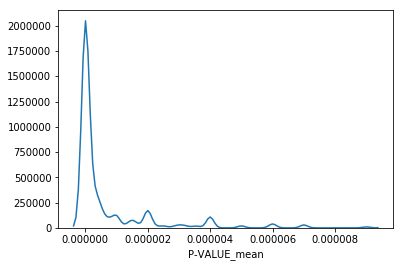

In [21]:
sns.distplot(a=snp_pval_mappedgene['P-VALUE_mean'].astype(float), hist=False)

In [22]:
# Write the SNP IDs to a text file.
# with open('ibd/all_unique_ibd_snp.txt', 'w') as f:
#     for snp in ebi_ibd_uniqueSNP:
#         f.write("%s\n" % snp)

snp_pval_mappedgene.to_csv("source_snps_ibd/snp_gwas_stats_ra.tab", sep="\t")

### Find LD SNPs using Ensembl API

In [23]:
def ensembl_LD(snp_list):
    start_time = time.time()
    
    # Check input
    if not isinstance(snp_list, list):
        raise TypeError("The input is not a list!")
        
    # Init empty dict for storing results and list for problem URLs
    ld_snps = {"query" : [],
             "result" : [],
             "r2" : [],
             "d_prime" : []}
    problems = []
    
    # Start up the non-blocking requests
    session = FuturesSession(max_workers=10)
    futures = [session.get("https://rest.ensembl.org/ld/human/{}/1000GENOMES:phase_3:EUR?".format(snp),
                          headers={ "Content-Type" : "application/json"}) for snp in snp_list]
    
    # As the requests complete, try to parse the data into the results, otherwise report a problem URL
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for rec in range(0, len(json_data)):
                ld_snps['query'].append(json_data[rec]['variation1'])
                ld_snps['result'].append(json_data[rec]['variation2'])
                ld_snps['r2'].append(json_data[rec]['r2'])
                ld_snps['d_prime'].append(json_data[rec]['d_prime'])
        except:
            problems.append(f.result().request.url)
            print("Found a problem. Will be requeued.")
            
    # Requeue the problem URLs in case there was a fluke
    session = FuturesSession(max_workers=8)
    futures = [session.get(url,
                          headers={ "Content-Type" : "application/json"}) for url in problems]
    problems2 = []
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for rec in range(0, len(json_data)):
                ld_snps['query'].append(json_data[rec]['variation1'])
                ld_snps['result'].append(json_data[rec]['variation2'])
                ld_snps['r2'].append(json_data[rec]['r2'])
                ld_snps['d_prime'].append(json_data[rec]['d_prime'])
            print("Succeeded on requeue!")
        except:
            problems2.append(f.result().request.url)
            print("Failed on a requeued problem.")
            
    print("Done!")
    print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
    ld_snps = pd.DataFrame.from_dict(ld_snps)
    return ld_snps, problems2

In [24]:
ld_snps, problems = ensembl_LD(ebi_ra_uniqueSNP)

Done!
Elapsed: 1.0 minutes 52.688323 seconds


In [25]:
problems

[]

Ok, so looks like the one that failed is a weirdo, we'll leave that one out.

I need to add the query SNPs to the table as well.

In [26]:
queries = {"query" : [],
             "result" : [],
             "r2" : [],
             "d_prime" : []}
for q in ld_snps['query'].unique():
    queries['query'].append(q)
    queries['result'].append(q)
    queries['r2'].append(1.0)
    queries['d_prime'].append(1.0)

In [27]:
ld_snps.tail()

,d_prime,query,r2,result
246919,0.999998,rs2745106,0.364083,rs139679237
246920,0.651375,rs2745106,0.190542,rs2667670
246921,0.638135,rs2745106,0.183917,rs111435394
246922,0.999999,rs2745106,0.068590,rs118035799
246923,0.693501,rs2745106,0.108471,rs41292291


In [28]:
ld_snps.to_csv("ld_expansion_ibd/ra_cleaned_gwas_ld_snps.csv")
ld_snps = pd.read_csv("ld_expansion_ibd/ra_cleaned_gwas_ld_snps.csv", index_col=0)
ld_snps

,d_prime,query,r2,result
0,0.862235,rs42041,0.209832,rs3814099
1,0.983559,rs42041,0.809796,rs535369995
2,0.367274,rs42041,0.114862,rs6944077
3,0.729398,rs42041,0.157637,rs35229910
4,0.987570,rs42041,0.655993,rs2282978
5,0.580059,rs42041,0.128580,rs10269874
6,0.502905,rs42041,0.168067,rs558095914
7,0.610596,rs42041,0.138636,rs76581721
8,0.676685,rs42041,0.074098,rs79279387
9,0.999863,rs42041,0.088010,rs10225965


In [29]:
ld_snps.r2 = ld_snps.r2.astype(float)

## Get SNP info
Now I need to get info about each SNP. This includes the coordinates, but also MAF, the allele string, etc. Again, this can be done with ENSEMBL.

Based on testing a bit, seem slike I can provide a maximum of 100 SNPs at a time. So, I'm going to have to engineer this a bit. I'll use the same Futures method as above.

In [30]:
len(ld_snps) / 100

2469.24

So, at 100 IDs per request, this would require 2469 request which is crazy. Instead, I'll filter for $R^2 \ge 0.8$ prior to searching for SNP data, which should eliminate most of those requests.

In [31]:
ld_snps_threshold = ld_snps[ld_snps.r2 >= 0.8]

In [32]:
len(ld_snps_threshold['result'].unique().tolist())/100

56.96

Great, now I only need to make 57 requests which is do-able I think.

In [33]:
def ensembl_snp_info(snp_list):
    start_time = time.time()
    
    # Check input
    if not isinstance(snp_list, list):
        raise TypeError("The input is not a list!")
        
    # Init empty dict for storing results and list for problem URLs
    result_dict = {'snp_id' : [],
              'MAF' :[],
               'minor_allele' : [],
               'consequence' : [],
              'allele_string' : [],
              'location' : [],
                  'synonyms' : []}
    problems = []
    
    # Start up the non-blocking requests in batches of 100 SNPs per request
    session = FuturesSession(max_workers=10)
    batch = 0
    futures = []
    if len(snp_list) < 100:
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
         headers={ "Content-Type" : "application/json",
                 "Accept" : "application/json"},
             data = json.dumps({'ids' : snp_list})))

    else:
        for i in range(0, len(snp_list)//100):
            futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
             headers={ "Content-Type" : "application/json",
                     "Accept" : "application/json"},
                 data = json.dumps({'ids' : snp_list[batch*100:(batch+1)*100]})))
            batch += 1
        
        # Add the last batch (with less than 100 IDs)
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
             headers={ "Content-Type" : "application/json",
                     "Accept" : "application/json"},
                 data = json.dumps({'ids' : snp_list[(batch)*100:]})))

    # As the requests complete, try to parse the data into the results_dict, otherwise report a problem URL
    n_complete = 0
    n_total = len(snp_list)
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for key in json_data.keys():
                result_dict['snp_id'].append(key)
                result_dict['MAF'].append(json_data[key]['MAF'])
                result_dict['minor_allele'].append(json_data[key]['minor_allele'])
                result_dict['consequence'].append(json_data[key]['most_severe_consequence'])
                result_dict['allele_string'].append(json_data[key]['mappings'][0]['allele_string'])
                result_dict['location'].append(json_data[key]['mappings'][0]['location'])
                result_dict['synonyms'].append(json_data[key]['synonyms'])
                n_complete += 1
                if n_complete % 1000 == 0: # Print progress every 1000 SNPs
                    print("Completed {} / {} ids".format(n_complete, n_total))
            
        except:
            problems.append(f.result().request.url)
            print("Found a problem.")
            print("Done!")
    print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
    snp_info = pd.DataFrame.from_dict(result_dict)
    return snp_info, problems

In [34]:
snp_list=ld_snps_threshold['result'].unique().tolist()
start_time = time.time()

# Check input
if not isinstance(snp_list, list):
    raise TypeError("The input is not a list!")

# Init empty dict for storing results and list for problem URLs
#     result_dict = {'snp_id' : [],
#               'MAF' :[],
#                'minor_allele' : [],
#                'consequence' : [],
#               'allele_string' : [],
#               'location' : [],
#                   'synonyms' : []}
result_dict = {}
problems = []

# Start up the non-blocking requests in batches of 100 SNPs per request
session = FuturesSession(max_workers=8)
batch = 0
futures = []

headers={"Content-Type" : "application/json",
             "Accept" : "application/json"}

if len(snp_list) < 100:
    futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
                                headers=headers,
                                data = json.dumps({'ids' : snp_list})))

else:
    for i in range(0, len(snp_list)//100):
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens",
                                    headers=headers,
                                    data = json.dumps({'ids' : snp_list[batch*100:(batch+1)*100]})))
        batch += 1

    # Add the last batch (with less than 100 IDs)
    futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
                                headers=headers,
                                data = json.dumps({'ids' : snp_list[(batch)*100:]})))

# As the requests complete, try to parse the data into the results_dict, otherwise report a problem URL
n_complete = 0
n_total = len(snp_list)
for f in as_completed(futures):
    try:
        json_data = f.result().json()
        result_dict.update(json_data)
        n_complete += 1
        print("Finished {} of {}".format(n_complete, n_total))
#             for key in json_data.keys():
#                 result_dict['snp_id'].append(key)
#                 result_dict['MAF'].append(json_data[key]['MAF'])
#                 result_dict['minor_allele'].append(json_data[key]['minor_allele'])
#                 result_dict['consequence'].append(json_data[key]['most_severe_consequence'])
#                 result_dict['allele_string'].append(json_data[key]['mappings'][0]['allele_string'])
#                 result_dict['location'].append(json_data[key]['mappings'][0]['location'])
#                 result_dict['synonyms'].append(json_data[key]['synonyms'])
#                 n_complete += 1
#                 if n_complete % 1000 == 0: # Print progress every 1,000 SNPs
#                     print("Completed {} / {} ids".format(n_complete, n_total))

    except:
#             problems.append(json.loads(f.result().request.body)['ids'])
        problems = problems + json.loads(f.result().request.body)['ids']
        print("Found a problem.")
print("Done!")
print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
#     snp_info = pd.DataFrame.from_dict(result_dict)


Finished 1 of 5696
Finished 2 of 5696
Finished 3 of 5696
Finished 4 of 5696
Finished 5 of 5696
Finished 6 of 5696
Finished 7 of 5696
Finished 8 of 5696
Finished 9 of 5696
Finished 10 of 5696
Finished 11 of 5696
Finished 12 of 5696
Finished 13 of 5696
Finished 14 of 5696
Finished 15 of 5696
Finished 16 of 5696
Finished 17 of 5696
Finished 18 of 5696
Finished 19 of 5696
Finished 20 of 5696
Finished 21 of 5696
Finished 22 of 5696
Finished 23 of 5696
Finished 24 of 5696
Finished 25 of 5696
Finished 26 of 5696
Finished 27 of 5696
Finished 28 of 5696
Finished 29 of 5696
Finished 30 of 5696
Finished 31 of 5696
Finished 32 of 5696
Finished 33 of 5696
Finished 34 of 5696
Finished 35 of 5696
Finished 36 of 5696
Finished 37 of 5696
Finished 38 of 5696
Finished 39 of 5696
Finished 40 of 5696
Finished 41 of 5696
Finished 42 of 5696
Finished 43 of 5696
Finished 44 of 5696
Finished 45 of 5696
Finished 46 of 5696
Finished 47 of 5696
Finished 48 of 5696
Finished 49 of 5696
Finished 50 of 5696
Finished 

In [35]:
all_snp_info = {'snp_id' : [],
              'MAF' :[],
               'minor_allele' : [],
               'consequence' : [],
              'allele_string' : [],
              'location' : [],
                  'synonyms' : []}
for key in result_dict.keys():
    all_snp_info['snp_id'].append(key)
    all_snp_info['MAF'].append(result_dict[key]['MAF'])
    all_snp_info['minor_allele'].append(result_dict[key]['minor_allele'])
    all_snp_info['synonyms'].append(result_dict[key]['synonyms'])
    all_snp_info['consequence'].append(result_dict[key]['most_severe_consequence'])
    # Some of these have missing mappings? Or maybe it isn't a list?
    try:
        all_snp_info['allele_string'].append(result_dict[key]['mappings'][0]['allele_string'])
        all_snp_info['location'].append(result_dict[key]['mappings'][0]['location'])
    except:
        print(result_dict[key])
        all_snp_info['allele_string'].append(None)
        all_snp_info['location'].append(None)

{'minor_allele': None, 'failed': 'Variant does not map to the genome', 'var_class': 'sequence alteration', 'most_severe_consequence': None, 'name': 'rs7364820', 'source': 'Variants (including SNPs and indels) imported from dbSNP', 'mappings': [], 'synonyms': ['rs74314916'], 'MAF': None, 'evidence': [], 'ambiguity': None}
{'minor_allele': None, 'synonyms': [], 'var_class': 'sequence alteration', 'most_severe_consequence': None, 'name': 'rs7368105', 'MAF': None, 'mappings': [], 'failed': 'Variant does not map to the genome', 'source': 'Variants (including SNPs and indels) imported from dbSNP', 'evidence': [], 'ambiguity': None}
{'minor_allele': None, 'failed': 'Variant does not map to the genome', 'var_class': 'sequence alteration', 'most_severe_consequence': None, 'name': 'rs7368072', 'source': 'Variants (including SNPs and indels) imported from dbSNP', 'mappings': [], 'synonyms': [], 'evidence': [], 'MAF': None, 'ambiguity': None}


In [36]:
len(all_snp_info['location'])

5596

In [37]:
all_snp_df = pd.DataFrame.from_dict(all_snp_info)

In [38]:
print(len(all_snp_df))
all_snp_df.head()

5596


,MAF,allele_string,consequence,location,minor_allele,snp_id,synonyms
0,0.091050,G/A,intergenic_variant,6:32627996-32627996,A,rs116517496,[rs117571922]
1,0.427500,A/G/T,intergenic_variant,6:32694183-32694183,A,rs73407347,"[rs115134247, rs116856514]"
2,0.085860,A/C,intron_variant,3:46231218-46231218,C,rs13060713,[]
3,0.214300,T/C/G,intergenic_variant,5:30404930-30404930,C,rs12522457,[]
4,0.008786,C/T,intron_variant,11:88914754-88914754,T,rs34553017,[]


So, doing a simple join using the queries and result snp_ids leaves a large number of IDs out. I tested this, and it seems to be due to synonymous SNP ids. So, I am querying a SNP, it is being found, but the ID being returned as the primary ID is different, preventing joining.

1. Ideally I would be able to use the SNP I provided in the query directly. I'm not sure if I can retrieve that from the request object or not. This would need to be possible because I am using asynchronous requests. I'll look around for this.
      - OK, so looks like this info is stored in r.request.body. *BUT, is the JSON returned in the same order as the input?*
      - NO, they are not. Probably due to something on the server side. So, I cannot use this method.

2. **Alternatively, I can retrieve the synonyms in addition to the other data, then take all of the non-joinable rows and replace their ID with whichever one of their synonyms is in our input id list.**

In [39]:
# Get the snp_info records with ids that don't match the ld_snps_threshold ids
bad_id = all_snp_df[~all_snp_df.snp_id.isin(ld_snps_threshold.result.unique())]
bad_id

,MAF,allele_string,consequence,location,minor_allele,snp_id,synonyms
67,0.42090,AAACAAACAAACAAACAAACAAACAAA/AAACAAACAAACAAACAA...,intron_variant,2:65366030-65366056,AAAC,rs3052978,"[rs60419906, rs201370805, rs140697125, rs12378..."
89,0.07348,AAAAAAAAAA/AAAAAAAAA/AAAAAAAAAAA,intron_variant,3:46292909-46292918,A,rs35691888,"[rs935989895, rs577589101, rs144736298, rs1390..."
107,0.39800,AAAAAAAAAAAAA/AAAAAAAAAA/AAAAAAAAAAA/AAAAAAAAA...,intron_variant,12:57627412-57627424,-,rs5798410,"[rs1405063653, rs201038545, rs397851272, rs143..."
137,0.41350,A/G/T,regulatory_region_variant,6:32533146-32533146,G,rs11965298,"[rs76315016, rs113260035, rs74375951]"
212,0.48140,ATA/A/ATATA,intron_variant,1:2608508-2608510,-,rs139100157,"[rs142350479, rs770735883, rs145601642]"
238,0.07828,A/G,synonymous_variant,6:32642012-32642012,G,rs1048134,"[NM_002122.3:c.372A>G, NM_002122.4:c.372A>G, N..."
248,0.33390,AAACAAACAAACAAA/AAACAAACAAA/AAACAAACAAACAAACAAA,intergenic_variant,3:27744532-27744546,-,rs35653193,"[rs59548652, rs145548114, rs1191447265]"
328,0.09034,TTTTTTTTTTT/TTTTTTTTT/TTTTTTTTTT/TTTTTTTTTTTT,intron_variant,12:57703763-57703773,-,rs34277509,"[rs60221535, rs77125396, rs75900281, rs3747367..."
341,0.48880,AGAGAGA/AGAGA,intron_variant,12:57711312-57711318,AG,rs35578706,"[rs398019774, rs78177968, rs151226467, rs14227..."
389,0.36760,CCCGGCCAGCGGCAAGGCCGCTCTCCCG/CCCG,intergenic_variant,6:32484252-32484279,-,rs67747745,"[rs141688355, rs112448440, rs67747746, rs14840..."


In [40]:
target_ids = ld_snps_threshold.result.unique()
for ix, row in bad_id.iterrows():
    for synonym in row['synonyms']:
        if synonym in target_ids:
            all_snp_df.loc[ix, 'snp_id'] = synonym

In [41]:
# See how many bad ids are left
len(all_snp_df[~all_snp_df.snp_id.isin(ld_snps_threshold.result.unique())])

0

Great! Seems like it worked. Now let's find out for sure - can we successfully join the `snp_info` dataframe with our `ld_snps_threshold` dataframe?

- *I just considered the possibility that some of our "unique" snps used as input might be synonyms of eachother... If so, we'll see some blank records.*

In [42]:
len(ld_snps_threshold)

8891

In [43]:
ld_snps_with_info = ld_snps_threshold.merge(all_snp_df, left_on='result', right_on='snp_id', how='left')
ld_snps_with_info

,d_prime,query,r2,result,MAF,allele_string,consequence,location,minor_allele,snp_id,synonyms
0,0.983559,rs42041,0.809796,rs535369995,0.13540,A/C,intron_variant,7:92629422-92629422,C,rs535369995,[]
1,0.989000,rs42041,0.811234,rs56201652,0.22160,G/A,intron_variant,7:92648802-92648802,A,rs56201652,[]
2,0.999999,rs42041,0.821761,rs42044,0.18350,T/G,intron_variant,7:92620826-92620826,G,rs42044,[rs3731363]
3,0.989053,rs42041,0.818869,rs6960181,0.13500,C/T,intron_variant,7:92648163-92648163,T,rs6960181,[]
4,1.000000,rs42041,0.975204,rs42035,0.14340,A/G/T,3_prime_UTR_variant,7:92610217-92610217,G,rs42035,"[rs11546335, NM_001145306.1:c.*4923T>C, NM_001..."
5,0.983604,rs42041,0.813639,rs11764331,0.13540,C/T,intron_variant,7:92653310-92653310,T,rs11764331,[]
6,1.000000,rs42041,1.000000,rs42043,0.17450,A/G,intron_variant,7:92618019-92618019,G,rs42043,"[rs10375770, rs3731374]"
7,0.999999,rs42041,0.821761,rs10953072,0.19230,A/C/T,intron_variant,7:92627025-92627025,C,rs10953072,[]
8,0.994908,rs42041,0.970181,rs42034,0.14400,A/G,3_prime_UTR_variant,7:92609830-92609830,G,rs42034,"[rs3173529, rs17688254, NM_001259.7:c.*5310T>C..."
9,0.989025,rs42041,0.815037,rs11767704,0.15400,C/T,intron_variant,7:92627061-92627061,T,rs11767704,[]


In [44]:
ld_snps_with_info[ld_snps_with_info.location.isna()]
# ld_snps_with_info[ld_snps_with_info.result=='rs67963613']

,d_prime,query,r2,result,MAF,allele_string,consequence,location,minor_allele,snp_id,synonyms
94,1.000000,rs3890745,1.000000,rs7364820,NaN,None,None,None,None,rs7364820,[rs74314916]
115,1.000000,rs3890745,1.000000,rs7368072,NaN,None,None,None,None,rs7368072,[]
214,1.000000,rs3890745,1.000000,rs7368105,NaN,None,None,None,None,rs7368105,[]
1861,0.981766,rs331463,0.856249,rs552140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1862,1.000000,rs331463,0.880511,rs981981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1863,0.963442,rs331463,0.824584,rs12574838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,0.981766,rs331463,0.856249,rs5030427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1865,0.975420,rs331463,0.943743,rs2303439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1866,0.981922,rs331463,0.864097,rs5030470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1867,0.991887,rs331463,0.983841,rs34071999,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perfect! Problem solved. All of our LD snps now have location information, and probably most of the other fields as well.

Now let's turn that location column into something we can convert to BED format.

In [45]:
coords = ld_snps_with_info['location'].str.split(r":|-", expand=True)
ld_snps_with_info['chrom'], ld_snps_with_info['start'], ld_snps_with_info['end'] = 'chr' + coords[0], coords[1], coords[2]
ld_snps_with_info.drop(columns=['location'], inplace=True)
ld_snps_with_info = ld_snps_with_info.dropna()

In [46]:
ld_snps_with_info

,d_prime,query,r2,result,MAF,allele_string,consequence,minor_allele,snp_id,synonyms,chrom,start,end
0,0.983559,rs42041,0.809796,rs535369995,0.13540,A/C,intron_variant,C,rs535369995,[],chr7,92629422,92629422
1,0.989000,rs42041,0.811234,rs56201652,0.22160,G/A,intron_variant,A,rs56201652,[],chr7,92648802,92648802
2,0.999999,rs42041,0.821761,rs42044,0.18350,T/G,intron_variant,G,rs42044,[rs3731363],chr7,92620826,92620826
3,0.989053,rs42041,0.818869,rs6960181,0.13500,C/T,intron_variant,T,rs6960181,[],chr7,92648163,92648163
4,1.000000,rs42041,0.975204,rs42035,0.14340,A/G/T,3_prime_UTR_variant,G,rs42035,"[rs11546335, NM_001145306.1:c.*4923T>C, NM_001...",chr7,92610217,92610217
5,0.983604,rs42041,0.813639,rs11764331,0.13540,C/T,intron_variant,T,rs11764331,[],chr7,92653310,92653310
6,1.000000,rs42041,1.000000,rs42043,0.17450,A/G,intron_variant,G,rs42043,"[rs10375770, rs3731374]",chr7,92618019,92618019
7,0.999999,rs42041,0.821761,rs10953072,0.19230,A/C/T,intron_variant,C,rs10953072,[],chr7,92627025,92627025
8,0.994908,rs42041,0.970181,rs42034,0.14400,A/G,3_prime_UTR_variant,G,rs42034,"[rs3173529, rs17688254, NM_001259.7:c.*5310T>C...",chr7,92609830,92609830
9,0.989025,rs42041,0.815037,rs11767704,0.15400,C/T,intron_variant,T,rs11767704,[],chr7,92627061,92627061


In [47]:
ld_snps_with_info.head()

,d_prime,query,r2,result,MAF,allele_string,consequence,minor_allele,snp_id,synonyms,chrom,start,end
0,0.983559,rs42041,0.809796,rs535369995,0.1354,A/C,intron_variant,C,rs535369995,[],chr7,92629422,92629422
1,0.989000,rs42041,0.811234,rs56201652,0.2216,G/A,intron_variant,A,rs56201652,[],chr7,92648802,92648802
2,0.999999,rs42041,0.821761,rs42044,0.1835,T/G,intron_variant,G,rs42044,[rs3731363],chr7,92620826,92620826
3,0.989053,rs42041,0.818869,rs6960181,0.1350,C/T,intron_variant,T,rs6960181,[],chr7,92648163,92648163
4,1.000000,rs42041,0.975204,rs42035,0.1434,A/G/T,3_prime_UTR_variant,G,rs42035,"[rs11546335, NM_001145306.1:c.*4923T>C, NM_001...",chr7,92610217,92610217


In [48]:
!mkdir ld_expansion_ra

mkdir: cannot create directory ‘ld_expansion_ra’: File exists


In [49]:
# Save the snp_info to a file
ld_snps_with_info.to_csv('ld_expansion_ra/ld_snps_info_new.tab', sep='\t', index=False)

In [50]:
ld_snps_with_info = pd.read_table("ld_expansion_ra/ld_snps_info_new.tab")

In [51]:
ld_snps_info_gwas = ld_snps_with_info.merge(snp_pval_mappedgene, left_on='query', right_on='SNPS_', how='left')

In [52]:
ld_snps_info_gwas = ld_snps_info_gwas[['query', 'snp_id', 'r2', 'd_prime', 'MAF', 'minor_allele',
       'consequence', 'allele_string', 'synonyms', 'chrom', 'start', 'end',
       'P-VALUE_mean', 'P-VALUE_listed', 'REPORTED GENE(S)_listed',
       'MAPPED_GENE_listed']]

In [53]:
ld_snps_info_gwas.to_csv('ld_expansion_ra/ld_snps_info_gwas_new.tab', sep='\t', index=False)

How many SNPs fall into each of the "consquence" categories?

In [54]:
ld_snps_info_gwas

,query,snp_id,r2,d_prime,MAF,minor_allele,consequence,allele_string,synonyms,chrom,start,end,P-VALUE_mean,P-VALUE_listed,REPORTED GENE(S)_listed,MAPPED_GENE_listed
0,rs42041,rs535369995,0.809796,0.983559,0.13540,C,intron_variant,A/C,[],chr7,92629422,92629422,4.000000e-06,[4e-06],[CDK6],[CDK6]
1,rs42041,rs56201652,0.811234,0.989000,0.22160,A,intron_variant,G/A,[],chr7,92648802,92648802,4.000000e-06,[4e-06],[CDK6],[CDK6]
2,rs42041,rs42044,0.821761,0.999999,0.18350,G,intron_variant,T/G,['rs3731363'],chr7,92620826,92620826,4.000000e-06,[4e-06],[CDK6],[CDK6]
3,rs42041,rs6960181,0.818869,0.989053,0.13500,T,intron_variant,C/T,[],chr7,92648163,92648163,4.000000e-06,[4e-06],[CDK6],[CDK6]
4,rs42041,rs42035,0.975204,1.000000,0.14340,G,3_prime_UTR_variant,A/G/T,"['rs11546335', 'NM_001145306.1:c.*4923T>C', 'N...",chr7,92610217,92610217,4.000000e-06,[4e-06],[CDK6],[CDK6]
5,rs42041,rs11764331,0.813639,0.983604,0.13540,T,intron_variant,C/T,[],chr7,92653310,92653310,4.000000e-06,[4e-06],[CDK6],[CDK6]
6,rs42041,rs42043,1.000000,1.000000,0.17450,G,intron_variant,A/G,"['rs10375770', 'rs3731374']",chr7,92618019,92618019,4.000000e-06,[4e-06],[CDK6],[CDK6]
7,rs42041,rs10953072,0.821761,0.999999,0.19230,C,intron_variant,A/C/T,[],chr7,92627025,92627025,4.000000e-06,[4e-06],[CDK6],[CDK6]
8,rs42041,rs42034,0.970181,0.994908,0.14400,G,3_prime_UTR_variant,A/G,"['rs3173529', 'rs17688254', 'NM_001259.7:c.*53...",chr7,92609830,92609830,4.000000e-06,[4e-06],[CDK6],[CDK6]
9,rs42041,rs11767704,0.815037,0.989025,0.15400,T,intron_variant,C/T,[],chr7,92627061,92627061,4.000000e-06,[4e-06],[CDK6],[CDK6]


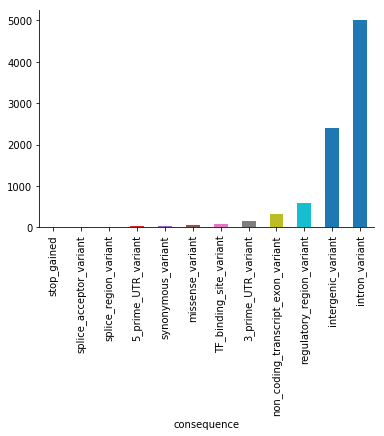

In [55]:
ld_snps_with_info.groupby('consequence').size().sort_values().plot(kind='bar')
sns.despine()

How many SNPs are on each chromosome?

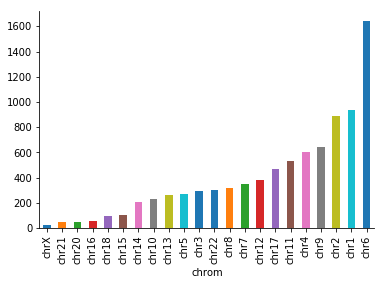

In [56]:
ld_snps_with_info.groupby('chrom').size().sort_values().plot(kind='bar')
sns.despine()

In [57]:
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [58]:
ld_snps_with_info.chrom.dropna()

0        chr7
1        chr7
2        chr7
3        chr7
4        chr7
5        chr7
6        chr7
7        chr7
8        chr7
9        chr7
10       chr7
11       chr7
12       chr7
13       chr7
14       chr7
15       chr7
16       chr7
17       chr7
18       chr7
19       chr7
20       chr7
21       chr7
22       chr7
23       chr7
24       chr7
25       chr7
26       chr7
27       chr7
28       chr7
29      chr20
        ...  
8681    chr12
8682    chr12
8683    chr12
8684    chr12
8685    chr12
8686    chr12
8687    chr12
8688    chr12
8689    chr12
8690    chr20
8691    chr20
8692    chr20
8693    chr20
8694    chr20
8695    chr16
8696    chr17
8697    chr17
8698    chr17
8699    chr17
8700    chr18
8701    chr18
8702    chr18
8703    chr18
8704    chr18
8705    chr18
8706    chr18
8707    chr18
8708    chr16
8709    chr16
8710    chr16
Name: chrom, Length: 8711, dtype: object

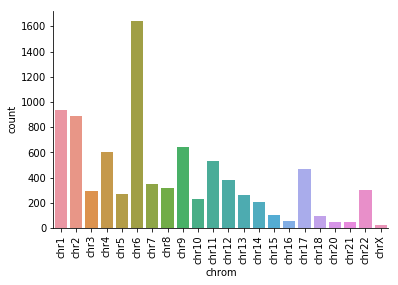

In [59]:
sns.countplot(data=ld_snps_with_info, x = 'chrom', order=sorted_nicely(ld_snps_with_info.chrom.unique()))
plt.xticks(rotation=90)
sns.despine()

So, you might expect that the number of SNPs per chromosome is correlated with chromosome size (it is, but only slightly, which indicates that IBD-associated SNPs are non-random, which makes sense). However, why are there so many more SNPs on chr6?

Simple answer: the HLA locus is on chromosome 6!

Now I'll export the SNPs as a BED file for the next step in analysis.

There are some odd rows which are unusual in that the end coordinate is smaller than the start, which is not valid BED. This is due to deletions, and is ok, but I'll need to remedy that.

In [60]:
ld_snps_with_info.head()

,d_prime,query,r2,result,MAF,allele_string,consequence,minor_allele,snp_id,synonyms,chrom,start,end
0,0.983559,rs42041,0.809796,rs535369995,0.1354,A/C,intron_variant,C,rs535369995,[],chr7,92629422,92629422
1,0.989000,rs42041,0.811234,rs56201652,0.2216,G/A,intron_variant,A,rs56201652,[],chr7,92648802,92648802
2,0.999999,rs42041,0.821761,rs42044,0.1835,T/G,intron_variant,G,rs42044,['rs3731363'],chr7,92620826,92620826
3,0.989053,rs42041,0.818869,rs6960181,0.1350,C/T,intron_variant,T,rs6960181,[],chr7,92648163,92648163
4,1.000000,rs42041,0.975204,rs42035,0.1434,A/G/T,3_prime_UTR_variant,G,rs42035,"['rs11546335', 'NM_001145306.1:c.*4923T>C', 'N...",chr7,92610217,92610217


In [61]:
ld_to_bed = ld_snps_with_info[['chrom', 'start']].copy()
ld_to_bed['end'] = ld_to_bed['start']
ld_to_bed['start'] = ld_to_bed['start'].astype(int) - 1 # Convert to 0-based coordinates
ld_to_bed['name'] = ld_snps_with_info['snp_id']
ld_to_bed = ld_to_bed.drop_duplicates()

In [64]:
ld_to_bed

,chrom,start,end,name
0,chr7,92629421,92629422,rs535369995
1,chr7,92648801,92648802,rs56201652
2,chr7,92620825,92620826,rs42044
3,chr7,92648162,92648163,rs6960181
4,chr7,92610216,92610217,rs42035
5,chr7,92653309,92653310,rs11764331
6,chr7,92618018,92618019,rs42043
7,chr7,92627024,92627025,rs10953072
8,chr7,92609829,92609830,rs42034
9,chr7,92627060,92627061,rs11767704


In [62]:
ld_to_bed.to_csv("ld_expansion_ra/ra_ld_snps_r2_0.8_new.bed", sep="\t", header=None, index=None)

In [63]:
!sort -k1,1 -k2,2n ld_expansion_ra/ra_ld_snps_r2_0.8_new.bed > ld_expansion_ra/ra_ld_snps_r2_0.8_new.bed.sorted.bed

### Find LD SNPs using NCBI's LDlink

Because of this formatting error, we're going to try a different method of getting SNPs in LD. NCBI provides an "LDlink" tool which will allow us to find all of the LD SNPs for a given query variant. I registered for an API token so we can now use HTTP requests to programmatically obtain all of the SNPs in LD. Biggest downside to this tool is that the genome build is hg19(GRCh37) and the MS SNPs are hg38 (*i think*). << **WRONG**. They are hg19.

In [170]:
import requests
import time
from io import StringIO
api_token = 'bb2472bededc'

In [171]:
snp_id = 'rs12443971'
payload = {'token' : api_token,
          'var' : snp_id,
          'pop' : 'EUR',
          'r2_d' : 'r2'}

In [172]:
def getLD(snps):
    '''Takes a list of SNP rsIDs or hg19 coordinates and returns all of the SNPs in LD'''
    st_time = time.time()
    api_token = 'bb2472bededc'
    problem_ids = []
    begin = 0
    for i, snp in enumerate(snps):
        payload = {'token' : api_token, # Dict of params for HTTP request
          'var' : snp,
          'pop' : 'EUR',
          'r2_d' : 'r2'}
        r = requests.get('https://ldlink.nci.nih.gov/LDlinkRest/ldproxy', params=payload) # Make HTTP request
        if "traceback" in str(r.content):
            problem_ids.append(snp)
            print("SNP %s was not found! Skipping..." % (snp))
            if i == begin:
                begin += 1
                ld_snps = []
        elif i == begin: # If the first query, instantiate the results df
            ld_snps = pd.read_table(StringIO(str(r.content, 'utf-8'))) # Parse the bytestring into a pandas DF
            ld_snps['Query'] = snp
        else: # If not the first query, add onto the existing results df
            more_snps = pd.read_table(StringIO(str(r.content, 'utf-8')))
            more_snps['Query'] = snp
            ld_snps = pd.concat(objs=[ld_snps, more_snps])
        print(time.ctime())
        print("Completed %d / %d SNPs!" % (i+1, len(snps))) # Progress reporting for sanity
        print("Total: %d linked SNPs" % (len(ld_snps)))
        print("Elapsed: %d minutes %d seconds" % (np.floor((time.time() - st_time)/60), (time.time() - st_time)%60))
        print("")
    return ld_snps, problem_ids

Josh uses **all_unique_SNP** file to expand on using LD using NCBI LDlink. But I couldn't find any file or variable with the name all_unique_SNP. It made sense logically to use the unique set of SNPs identified for IBD from EBI (that was used for GWAS LD exapnsion) to be also used as the input file for the NCBI LDLink expansion. Hence I am using **ebi_ibs_uniqueSNP** for the NCBI LDlink expansion of SNPs. <br>
The only concern here is the file **all_unique_snp** has only 531 entries while the file **ebi_ibd_uniqueSNP** has 665 entries

In [173]:
len(ebi_ra_uniqueSNP)

334

In [174]:
### DO NOT RUN THIS AGAIN! It takes > 2 hours to complete.
all_LD, problem_ids = getLD(ebi_ra_uniqueSNP)

Mon Jun 28 22:11:28 2021
Completed 1 / 334 SNPs!
Total: 15875 linked SNPs
Elapsed: 0 minutes 24 seconds

Mon Jun 28 22:11:38 2021
Completed 2 / 334 SNPs!
Total: 16648 linked SNPs
Elapsed: 0 minutes 34 seconds

Mon Jun 28 22:11:49 2021
Completed 3 / 334 SNPs!
Total: 17814 linked SNPs
Elapsed: 0 minutes 45 seconds

Mon Jun 28 22:12:03 2021
Completed 4 / 334 SNPs!
Total: 18759 linked SNPs
Elapsed: 0 minutes 59 seconds

Mon Jun 28 22:12:13 2021
Completed 5 / 334 SNPs!
Total: 19440 linked SNPs
Elapsed: 1 minutes 9 seconds

Mon Jun 28 22:12:26 2021
Completed 6 / 334 SNPs!
Total: 20549 linked SNPs
Elapsed: 1 minutes 22 seconds

Mon Jun 28 22:12:54 2021
Completed 7 / 334 SNPs!
Total: 36401 linked SNPs
Elapsed: 1 minutes 50 seconds

Mon Jun 28 22:13:08 2021
Completed 8 / 334 SNPs!
Total: 37162 linked SNPs
Elapsed: 2 minutes 4 seconds

Mon Jun 28 22:13:19 2021
Completed 9 / 334 SNPs!
Total: 37427 linked SNPs
Elapsed: 2 minutes 15 seconds

Mon Jun 28 22:13:33 2021
Completed 10 / 334 SNPs!
Total: 

Mon Jun 28 22:27:18 2021
Completed 78 / 334 SNPs!
Total: 202196 linked SNPs
Elapsed: 16 minutes 14 seconds

Mon Jun 28 22:27:32 2021
Completed 79 / 334 SNPs!
Total: 203445 linked SNPs
Elapsed: 16 minutes 28 seconds

Mon Jun 28 22:27:54 2021
Completed 80 / 334 SNPs!
Total: 219395 linked SNPs
Elapsed: 16 minutes 50 seconds

Mon Jun 28 22:28:03 2021
Completed 81 / 334 SNPs!
Total: 219901 linked SNPs
Elapsed: 16 minutes 59 seconds

Mon Jun 28 22:28:17 2021
Completed 82 / 334 SNPs!
Total: 220579 linked SNPs
Elapsed: 17 minutes 13 seconds

Mon Jun 28 22:28:26 2021
Completed 83 / 334 SNPs!
Total: 221585 linked SNPs
Elapsed: 17 minutes 22 seconds

Mon Jun 28 22:28:38 2021
Completed 84 / 334 SNPs!
Total: 222763 linked SNPs
Elapsed: 17 minutes 34 seconds

Mon Jun 28 22:28:46 2021
Completed 85 / 334 SNPs!
Total: 224194 linked SNPs
Elapsed: 17 minutes 42 seconds

Mon Jun 28 22:28:56 2021
Completed 86 / 334 SNPs!
Total: 225239 linked SNPs
Elapsed: 17 minutes 52 seconds

Mon Jun 28 22:29:05 2021
Com

Mon Jun 28 22:41:14 2021
Completed 153 / 334 SNPs!
Total: 287179 linked SNPs
Elapsed: 30 minutes 10 seconds

Mon Jun 28 22:41:30 2021
Completed 154 / 334 SNPs!
Total: 296353 linked SNPs
Elapsed: 30 minutes 26 seconds

Mon Jun 28 22:41:41 2021
Completed 155 / 334 SNPs!
Total: 297420 linked SNPs
Elapsed: 30 minutes 37 seconds

Mon Jun 28 22:41:50 2021
Completed 156 / 334 SNPs!
Total: 297757 linked SNPs
Elapsed: 30 minutes 46 seconds

Mon Jun 28 22:42:00 2021
Completed 157 / 334 SNPs!
Total: 298241 linked SNPs
Elapsed: 30 minutes 56 seconds

Mon Jun 28 22:42:23 2021
Completed 158 / 334 SNPs!
Total: 313791 linked SNPs
Elapsed: 31 minutes 19 seconds

Mon Jun 28 22:42:34 2021
Completed 159 / 334 SNPs!
Total: 314766 linked SNPs
Elapsed: 31 minutes 30 seconds

Mon Jun 28 22:42:44 2021
Completed 160 / 334 SNPs!
Total: 316091 linked SNPs
Elapsed: 31 minutes 40 seconds

Mon Jun 28 22:42:57 2021
Completed 161 / 334 SNPs!
Total: 317185 linked SNPs
Elapsed: 31 minutes 53 seconds

Mon Jun 28 22:43:11

Mon Jun 28 22:56:25 2021
Completed 228 / 334 SNPs!
Total: 476989 linked SNPs
Elapsed: 45 minutes 21 seconds

Mon Jun 28 22:56:41 2021
Completed 229 / 334 SNPs!
Total: 478130 linked SNPs
Elapsed: 45 minutes 37 seconds

Mon Jun 28 22:56:51 2021
Completed 230 / 334 SNPs!
Total: 479224 linked SNPs
Elapsed: 45 minutes 47 seconds

Mon Jun 28 22:57:01 2021
Completed 231 / 334 SNPs!
Total: 479653 linked SNPs
Elapsed: 45 minutes 57 seconds

Mon Jun 28 22:57:10 2021
Completed 232 / 334 SNPs!
Total: 481216 linked SNPs
Elapsed: 46 minutes 6 seconds

Mon Jun 28 22:57:22 2021
Completed 233 / 334 SNPs!
Total: 483065 linked SNPs
Elapsed: 46 minutes 18 seconds

Mon Jun 28 22:57:33 2021
Completed 234 / 334 SNPs!
Total: 484539 linked SNPs
Elapsed: 46 minutes 29 seconds

Mon Jun 28 22:57:42 2021
Completed 235 / 334 SNPs!
Total: 485511 linked SNPs
Elapsed: 46 minutes 38 seconds

Mon Jun 28 22:57:57 2021
Completed 236 / 334 SNPs!
Total: 486052 linked SNPs
Elapsed: 46 minutes 53 seconds

Mon Jun 28 22:58:10 

Mon Jun 28 23:10:33 2021
Completed 303 / 334 SNPs!
Total: 590509 linked SNPs
Elapsed: 59 minutes 29 seconds

Mon Jun 28 23:10:46 2021
Completed 304 / 334 SNPs!
Total: 590916 linked SNPs
Elapsed: 59 minutes 42 seconds

Mon Jun 28 23:10:56 2021
Completed 305 / 334 SNPs!
Total: 592037 linked SNPs
Elapsed: 59 minutes 52 seconds

Mon Jun 28 23:11:09 2021
Completed 306 / 334 SNPs!
Total: 592483 linked SNPs
Elapsed: 60 minutes 5 seconds

Mon Jun 28 23:11:19 2021
Completed 307 / 334 SNPs!
Total: 593097 linked SNPs
Elapsed: 60 minutes 15 seconds

Mon Jun 28 23:11:26 2021
Completed 308 / 334 SNPs!
Total: 594014 linked SNPs
Elapsed: 60 minutes 22 seconds

Mon Jun 28 23:11:40 2021
Completed 309 / 334 SNPs!
Total: 594869 linked SNPs
Elapsed: 60 minutes 36 seconds

Mon Jun 28 23:11:51 2021
Completed 310 / 334 SNPs!
Total: 595542 linked SNPs
Elapsed: 60 minutes 47 seconds

Mon Jun 28 23:12:00 2021
Completed 311 / 334 SNPs!
Total: 596993 linked SNPs
Elapsed: 60 minutes 56 seconds

Mon Jun 28 23:12:09 

In [175]:
all_LD.to_csv("all_LD_RA_SNPs.tab", sep="\t")

In [176]:
all_LD.to_pickle("all_LD_RA_SNPs.pkl")

In [177]:
all_LD = pd.read_pickle("all_LD_RA_SNPs.pkl")

In [178]:
all_LD.head()

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
0,rs6457617,chr6:32663851,(C/T),0.4553,0,1.0,1.0,"C=C,T=T",6,NaN,rs6457617
1,rs9275230,chr6:32660442,(A/G),0.4553,-3409,1.0,1.0,"C=A,T=G",7,NaN,rs6457617
2,rs4711304,chr6:32660170,(T/C),0.4553,-3681,1.0,1.0,"C=T,T=C",5,NaN,rs6457617
3,rs4713582,chr6:32660051,(T/C),0.4553,-3800,1.0,1.0,"C=T,T=C",1f,NaN,rs6457617
4,rs5002702,chr6:32659158,(G/A),0.4553,-4693,1.0,1.0,"C=G,T=A",6,NaN,rs6457617


In [179]:
all_LD.shape

(618554, 11)

### How do the ENSEMBL and LDLINK methods compare?
It turns out that the ENSEMBL database has a 500 kb "window size" whereas LDlink uses a window that is "500 kb +/- of the query"

As a result, LDlink pulls almost twice as many raw SNPs. However, when we filter for R2 >= 0.8, they are extremely comparable.

What are the differences?

The LDlink approach finds 929 SNPs not found by the ENSEMBL method
ENSEMBL method finds 990 SNPs not found by LDlink method.

In [180]:
from matplotlib_venn import venn2

In [181]:
ens_ld_unique = set(np.unique(ld_snps.loc[ld_snps.r2 >= 0.8, 'result'].tolist() + ld_snps['query'].tolist()))
ldlink_unique = set(all_LD.loc[all_LD.R2 >= 0.8,'RS_Number'].unique().tolist())
# np.setdiff1d(ens_ld_unique, ldlink_unique, assume_unique=True)
print(len(ens_ld_unique))
print(len(ldlink_unique))


5877
5523


In [182]:
print(len(ldlink_unique - ens_ld_unique))
print(len(ens_ld_unique - ldlink_unique))

237
591


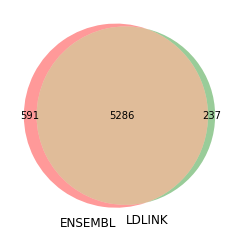

In [183]:
venn2([ens_ld_unique, ldlink_unique], ('ENSEMBL', 'LDLINK'))
plt.show()

Why the difference? Maybe the ones found by LDlink are more than 250 kb away from the query...

ALSO. Turns out LDlink adds the query to the results automatically. So, simply including that boosted ENSEMBL.

In [184]:
problems # These coordinates are hg19

[]

In [185]:
ldlink_unique - ens_ld_unique

{'.',
 'rs10649173',
 'rs10688287',
 'rs10690159',
 'rs10714826',
 'rs11066301',
 'rs11066309',
 'rs11066320',
 'rs11078894',
 'rs11078895',
 'rs111547585',
 'rs11216973',
 'rs112596164',
 'rs112777438',
 'rs112783914',
 'rs112947356',
 'rs113027967',
 'rs113211383',
 'rs113564629',
 'rs11393359',
 'rs114082462',
 'rs114208728',
 'rs114237393',
 'rs114253231',
 'rs114289808',
 'rs11431247',
 'rs11464272',
 'rs114895478',
 'rs114926982',
 'rs115106209',
 'rs11513729',
 'rs115328288',
 'rs115580594',
 'rs115596275',
 'rs115610745',
 'rs11574915',
 'rs115962869',
 'rs11655972',
 'rs116710059',
 'rs11680476',
 'rs117926830',
 'rs12950186',
 'rs13129806',
 'rs13132308',
 'rs13137072',
 'rs13140464',
 'rs13320485',
 'rs138545978',
 'rs138569483',
 'rs138738957',
 'rs139564004',
 'rs139605600',
 'rs139756224',
 'rs139837574',
 'rs139911304',
 'rs140359842',
 'rs140430576',
 'rs140761059',
 'rs141031211',
 'rs141208519',
 'rs141442738',
 'rs141727970',
 'rs141758348',
 'rs142225146',
 'rs14280

In [186]:
all_LD = all_LD.reset_index(drop=True)
all_LD[((all_LD.R2 >= 0.8) & all_LD.RS_Number.isin(ldlink_unique - ens_ld_unique))]

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
16664,rs35955733,chr1:2561259,(CCC/-),0.3091,7635,1.0000,1.0000,"T=-,C=CCC",.,NaN,rs3890745
16737,.,chr1:2523978,(-/C),0.3121,-29646,0.9860,0.9587,"T=-,C=C",5,.,rs3890745
16749,rs139756224,chr1:2625154,(A/G),0.3201,71530,0.9953,0.9416,"T=G,C=A",5,NaN,rs3890745
16752,rs372546989,chr1:2624504,(A/C),0.3101,70880,0.9627,0.9225,"T=C,C=A",5,NaN,rs3890745
16757,rs58240187,chr1:2557376,(-/GAA),0.3290,3752,1.0000,0.9125,"T=GAA,C=-",2c,NaN,rs3890745
...,...,...,...,...,...,...,...,...,...,...,...
602204,rs72196566,chr7:100968623,(AGCC/-),0.0686,25562,1.0000,0.9845,"G=AGCC,A=-",.,NaN,rs10275421
602211,.,chr7:100981361,(A/T),0.0636,38300,0.9832,0.9060,"G=A,A=T",6,.,rs10275421
608037,rs59482735,chr9:123643426,(-/AA),0.3300,-62956,0.9624,0.8116,"T=-,C=AA",6,NaN,rs2900180
609691,rs35852530,chr10:105392616,(A/-),0.1839,-20424,0.9697,0.8010,"A=A,G=-",.,NaN,rs4918037


# FIX THE hg38 COORDINATE INPUT SNPS

All of the SNPs that were input as chromosomal coordinates instead of rs numbers may be incorrect, ~~because they were hg38 coordinates and LDlink works with hg19 coordinates~~. **Actually, these are hg19 to begin with.** Therefore, we will now correct that subset of SNPs. There are only 20 of these, so should be easy to reprocess.

In [187]:
def linkagePlots(df):
    f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
    sns.distplot(df.R2, ax = ax[0])
    sns.distplot(df.Dprime, ax=ax[1])
    sns.scatterplot(x=df.R2, y=df.Dprime, ax=ax[2], markers=".")
    f.tight_layout()

What is the typical distance of the LD SNPs from the query?

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


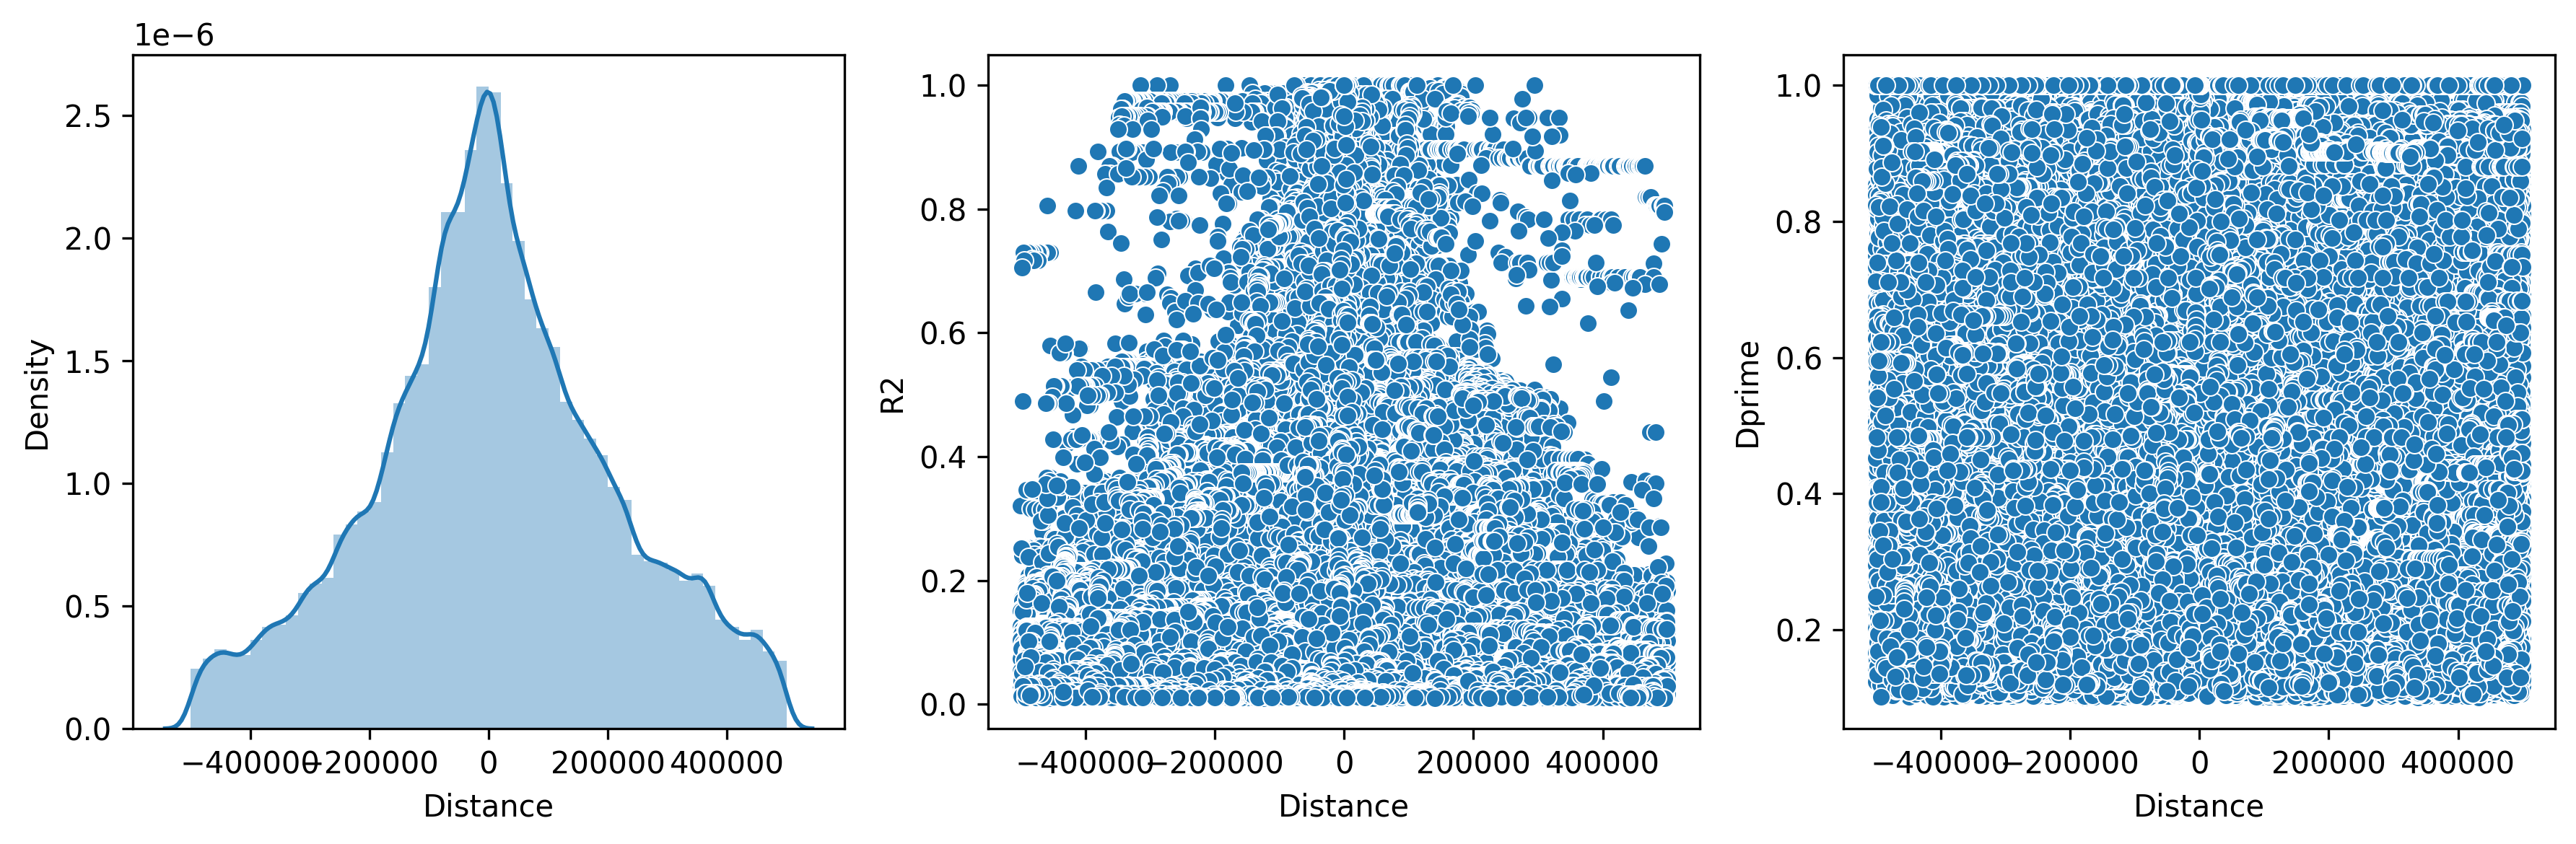

In [188]:
f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
sns.distplot(all_LD.Distance, ax=ax[0])
sns.scatterplot(x=all_LD.Distance, y = all_LD.R2, ax = ax[1])
sns.scatterplot(x=all_LD.Distance, y = all_LD.Dprime, ax = ax[2])
f.tight_layout()

We can see that there is a hard cutoff at 500kb up or downstream of the query, and that there is some trend between distance and R2 value, as might be expected. Interestingly, there is not clear association with Dprime (but there is a great deal of overplotting).

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


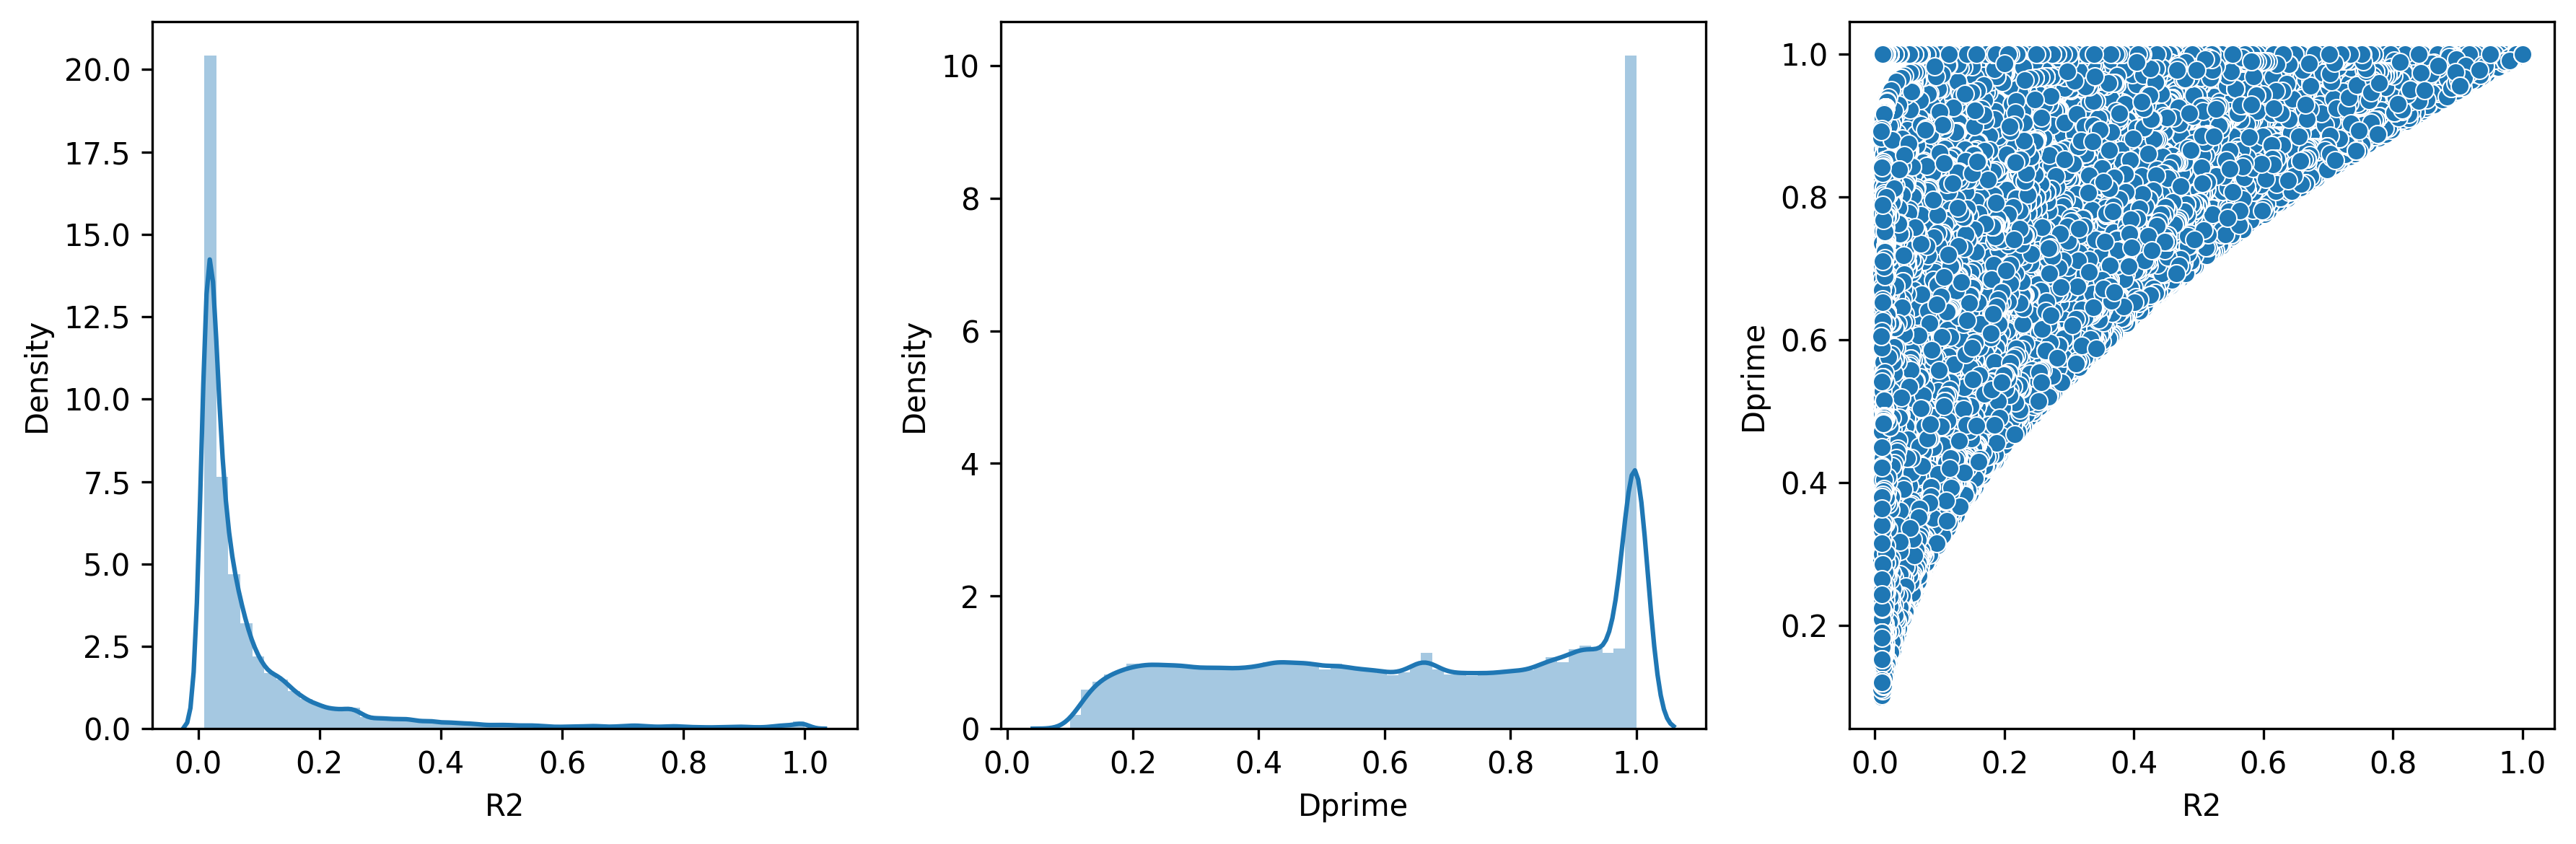

In [189]:
linkagePlots(all_LD)

In [190]:
len(all_LD.RS_Number.unique()) / len(all_LD)

0.3347209782816052

Only 35% of the returned LD SNPs are unique.<br>

However, the R2 values are going to depend on the query SNP, and all query SNP IDs used were unique. Therefore, we should filter based on R2 or Dprime *prior* to removing the redundant values.<br>



In [191]:
all_LD_cutoff = all_LD[all_LD.R2 >= 0.8]
all_LD_cutoff

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
0,rs6457617,chr6:32663851,(C/T),0.4553,0,1.0000,1.0000,"C=C,T=T",6,NaN,rs6457617
1,rs9275230,chr6:32660442,(A/G),0.4553,-3409,1.0000,1.0000,"C=A,T=G",7,NaN,rs6457617
2,rs4711304,chr6:32660170,(T/C),0.4553,-3681,1.0000,1.0000,"C=T,T=C",5,NaN,rs6457617
3,rs4713582,chr6:32660051,(T/C),0.4553,-3800,1.0000,1.0000,"C=T,T=C",1f,NaN,rs6457617
4,rs5002702,chr6:32659158,(G/A),0.4553,-4693,1.0000,1.0000,"C=G,T=A",6,NaN,rs6457617
...,...,...,...,...,...,...,...,...,...,...,...
617667,rs1005133,chr22:19738355,(C/T),0.2435,0,1.0000,1.0000,"C=C,T=T",5,NaN,rs1005133
618064,rs2745106,chr16:1541461,(C/T),0.1163,0,1.0000,1.0000,"C=C,T=T",4,NaN,rs2745106
618065,rs2667678,chr16:1541303,(G/A),0.1163,-158,1.0000,1.0000,"C=G,T=A",4,NaN,rs2745106
618066,rs28613120,chr16:1545067,(C/T),0.1103,3606,0.9490,0.8487,"C=C,T=T",5,NaN,rs2745106


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


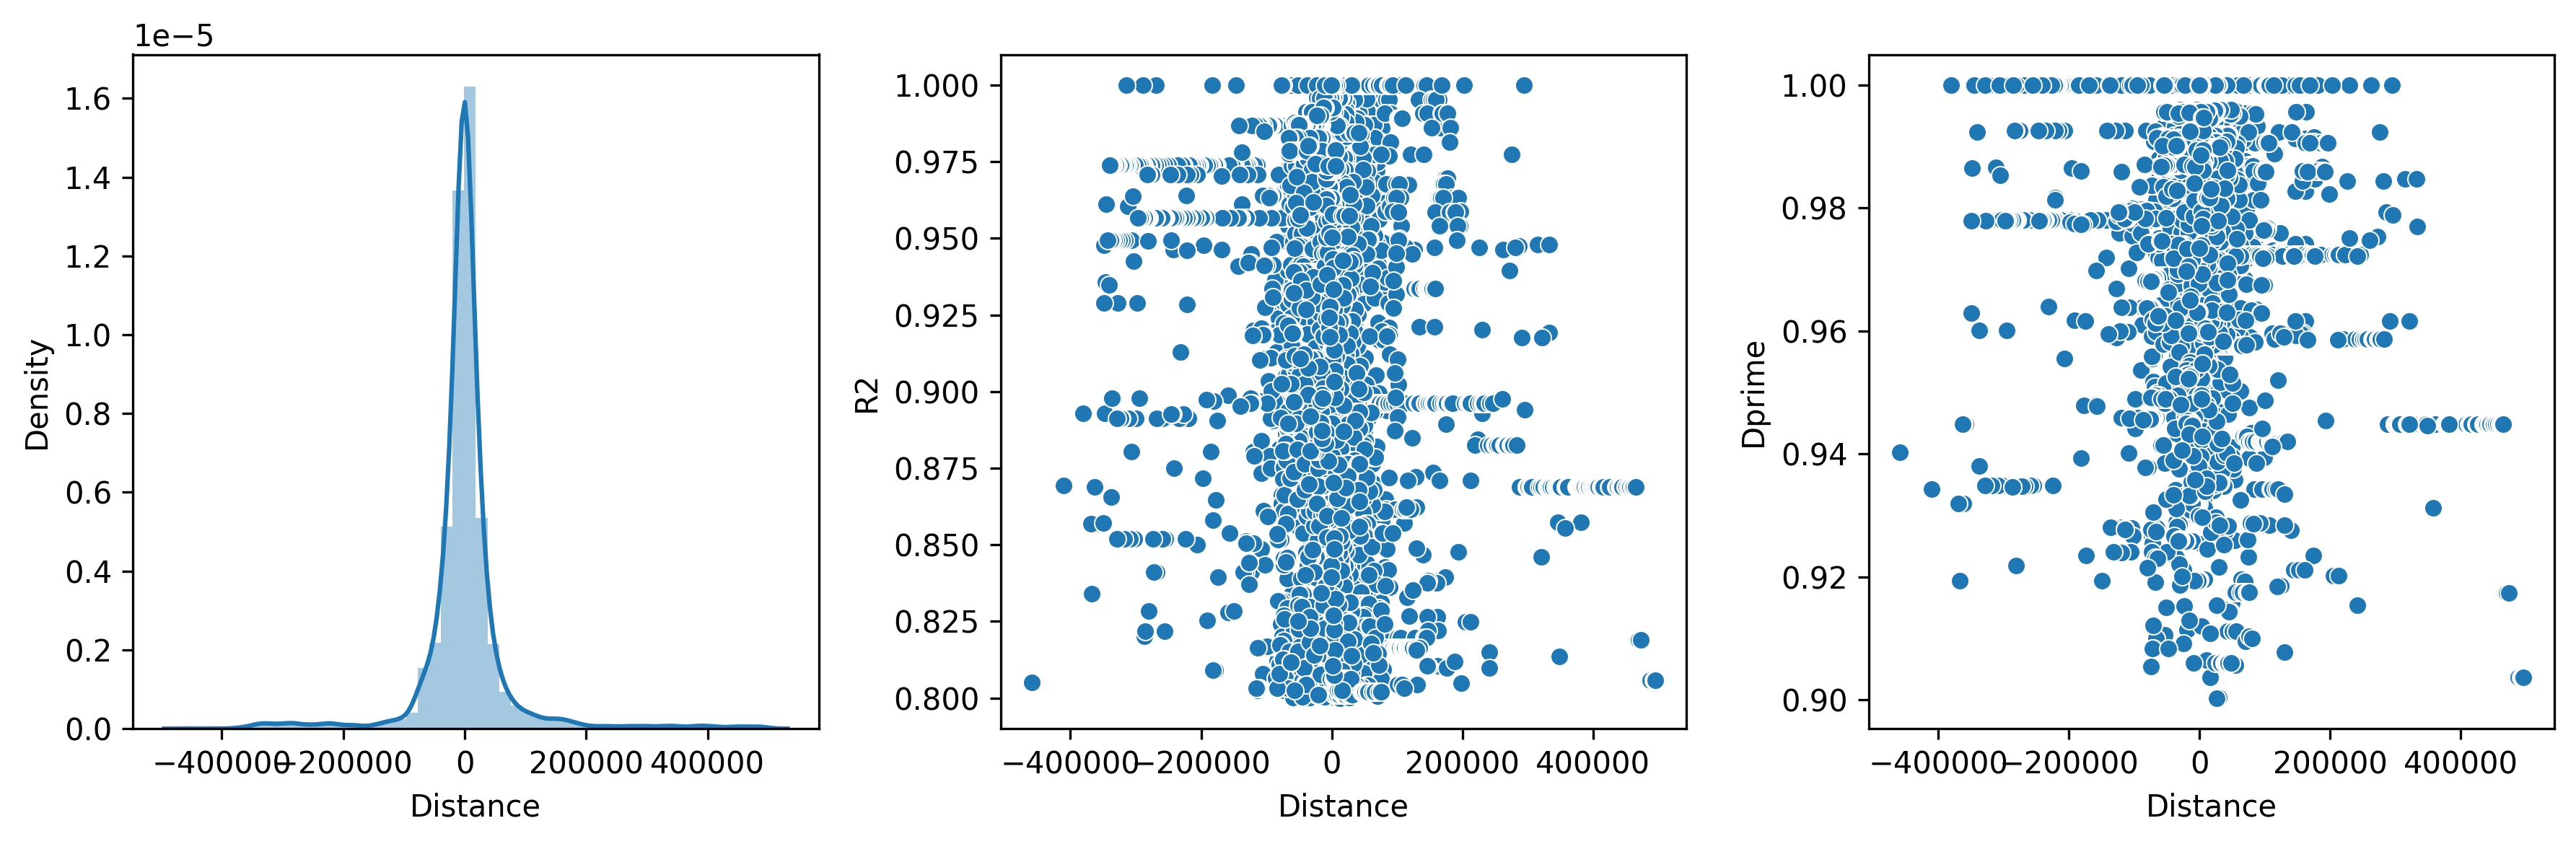

In [192]:
f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
sns.distplot(all_LD_cutoff.Distance, ax=ax[0])
sns.scatterplot(x=all_LD_cutoff.Distance, y = all_LD_cutoff.R2, ax = ax[1])
sns.scatterplot(x=all_LD_cutoff.Distance, y = all_LD_cutoff.Dprime, ax = ax[2])
f.tight_layout()

Now we see that SNPs with R2 >= 0.8 have a much tighter distance distribution.

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


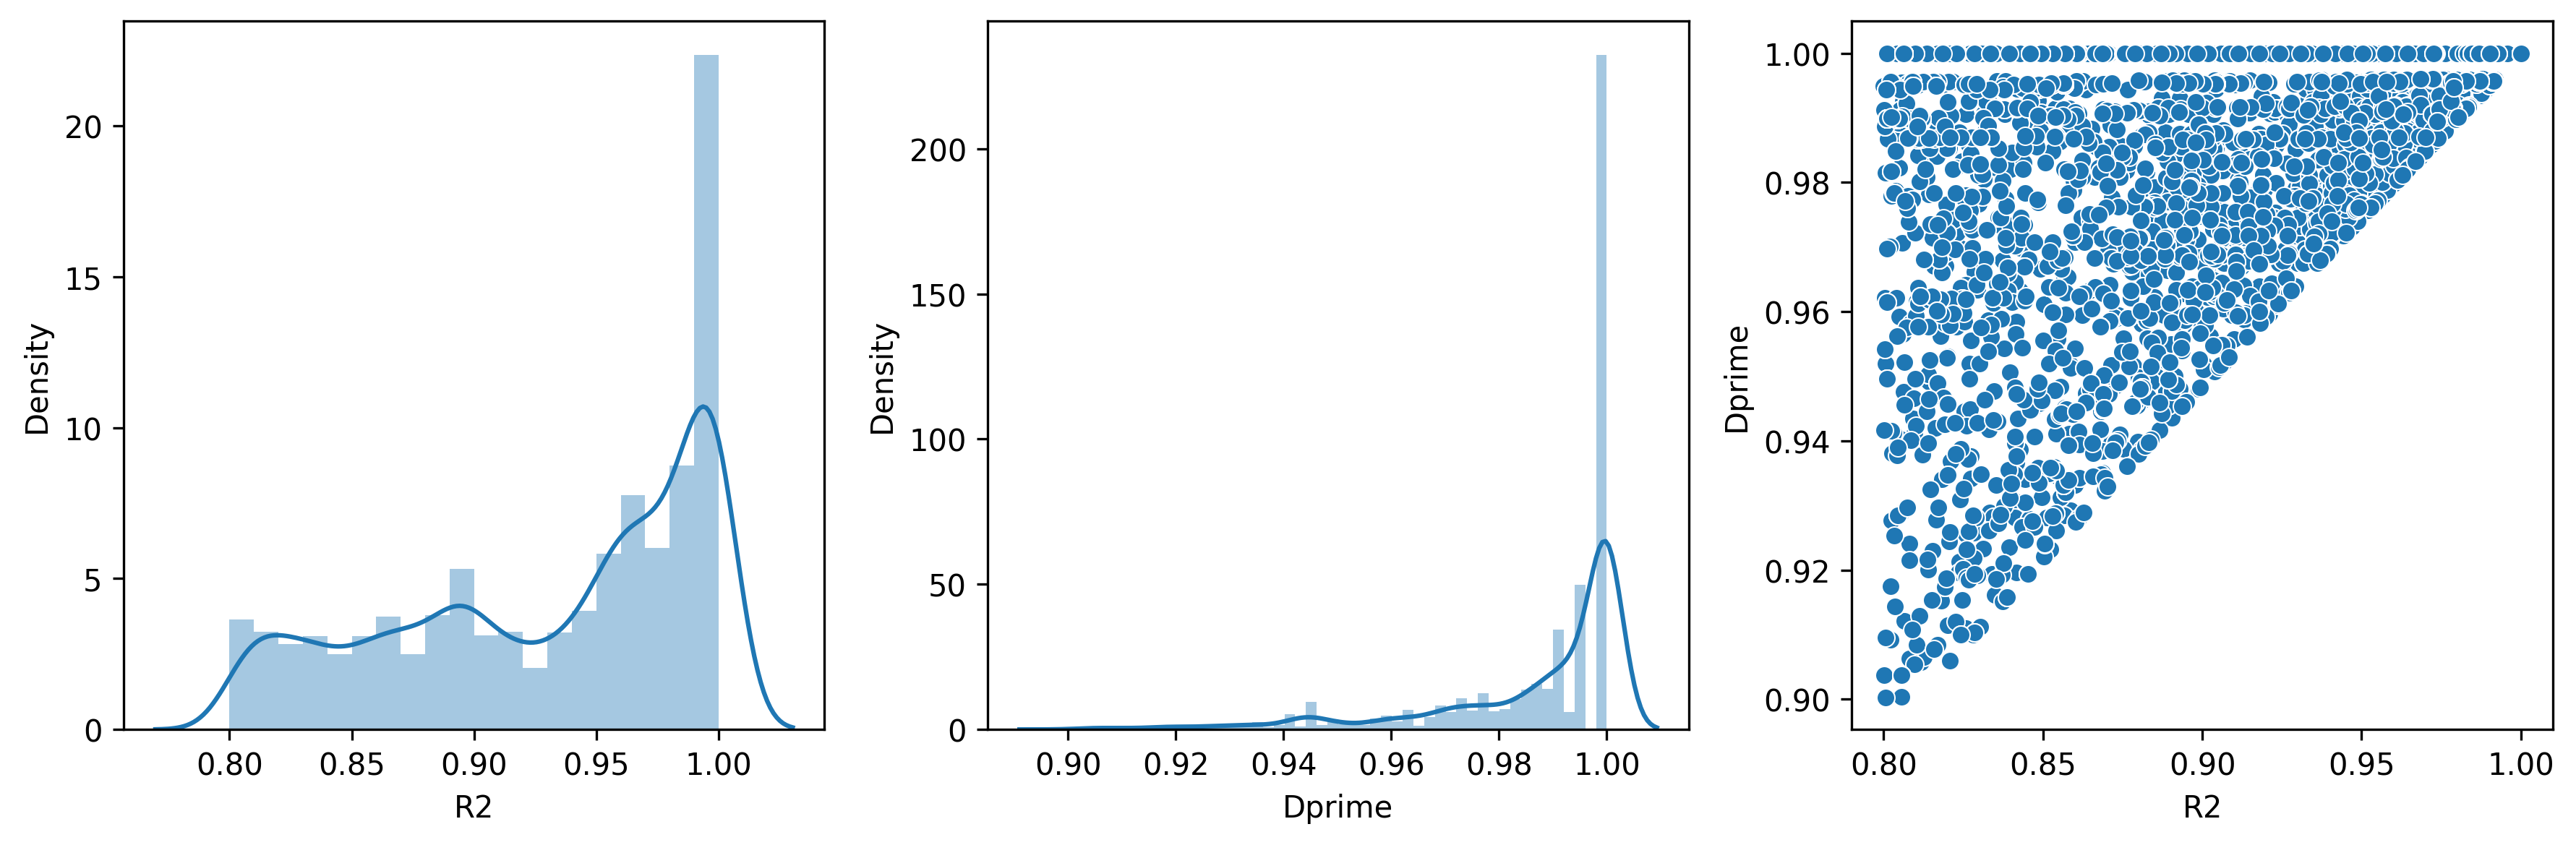

In [193]:
linkagePlots(all_LD_cutoff)

In [194]:
print("Percent Unique: %.4f" % (len(all_LD_cutoff.RS_Number.unique()) / len(all_LD_cutoff)))
print("Number of unique SNPs R2 >= 0.8: %d" % (len(all_LD_cutoff.Coord.unique())))

Percent Unique: 0.6122
Number of unique SNPs R2 >= 0.8: 5592


Now, ~61% of the SNPs are unique. However, there are some SNPs with no rs number that have "." as the value for RS_Number. These may be unique, and the coordinates should instead be compared. How many of them are there?

In [195]:
sum(['.' in x for x in all_LD_cutoff.RS_Number])

103

We can get the unique SNPs by first extracting the SNPs having an rs#, then using unique on those. Finally, for all SNPs *not* having an rs#, we will require that they have unique chromosomal coordinates. **Actually** we will just look for unique coordinates, which fixes the RS# problem.

In [196]:
# all_LD_cutoff_unique = all_LD_cutoff[['rs' in x for x in all_LD_cutoff.RS_Number]].drop_duplicates(subset='RS_Number')

In [197]:
# all_LD_cutoff_unique = pd.concat([all_LD_cutoff_unique, all_LD_cutoff[['.' in x for x in all_LD_cutoff.RS_Number]].drop_duplicates(subset='Coord')])

Couldn't I just filter them all based on chromosomal coordinate? Or do some have different alleles (that wouldn't really make sense as all alleles should be accounted for?)

In [198]:
all_LD_cutoff_unique = all_LD_cutoff.drop_duplicates(subset='Coord')

In [199]:
len(all_LD_cutoff_unique) # Both methods get essentially the same number (difference of 1)

5592

In [200]:
all_LD_cutoff_unique.head()

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
0,rs6457617,chr6:32663851,(C/T),0.4553,0,1.0,1.0,"C=C,T=T",6,NaN,rs6457617
1,rs9275230,chr6:32660442,(A/G),0.4553,-3409,1.0,1.0,"C=A,T=G",7,NaN,rs6457617
2,rs4711304,chr6:32660170,(T/C),0.4553,-3681,1.0,1.0,"C=T,T=C",5,NaN,rs6457617
3,rs4713582,chr6:32660051,(T/C),0.4553,-3800,1.0,1.0,"C=T,T=C",1f,NaN,rs6457617
4,rs5002702,chr6:32659158,(G/A),0.4553,-4693,1.0,1.0,"C=G,T=A",6,NaN,rs6457617


## Convert coordinates to hg38 and output BED file
Now that we have all SNPs in LD with MS GWAS SNPs, we need to generate a file for visualization and for overlapping with ATAC peaks. We have extended our original list of SNPs from 531 to 9453, but the coordinate system is hg37. We need to convert them to hg38, which we will do with UCSC's liftOver tool. We will then output a BED file which we can use to visualize in IGV and to assess overlaps with ATAC peaks.

In [201]:
# Step 1: convert coordinates to BED (Do we need to adjust for 0-based, half-open?)
all_LD_cutoff_bed = all_LD_cutoff_unique.Coord.str.split(':', expand=True)
all_LD_cutoff_bed[1] = all_LD_cutoff_bed[1].astype(int)
all_LD_cutoff_bed[2] = all_LD_cutoff_bed[1] + 1
all_LD_cutoff_bed[3] = all_LD_cutoff_unique.RS_Number

In [203]:
all_LD_cutoff_bed.to_csv("all_LD_SNPs_RA_R0.8unique_hg19.bed", sep="\t", quoting=None, header=False, index=False)

In [204]:
%%bash
/Users/rv103/Downloads/liftOver \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_RA_R0.8unique_hg19.bed \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/source_snps/hg19ToHg38.over.chain \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_RA_R0.8unique_hg38.bed \
lift_unmapped.bed

Reading liftover chains
Mapping coordinates


In [205]:
# Output the query SNPs also NEED TO FIX THE INPUT HG38 IDS*****
query_snps = all_LD[all_LD.Distance == 0]
query_snps_bed = query_snps.Coord.str.split(':', expand=True)
query_snps_bed[1] = query_snps_bed[1].astype(int)
query_snps_bed[2] = query_snps_bed[1] + 1
query_snps_bed[3] = query_snps.Query

In [206]:
query_snps_bed.to_csv("query_gwas_snps_ra_hg19.bed", sep="\t", quoting=None, header=False, index=False)

In [207]:
%%bash
/Users/rv103/Downloads/liftOver \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/query_gwas_snps_ra_hg19.bed \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/source_snps/hg19ToHg38.over.chain \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/query_gwas_snps_ra_hg38.bed \
lift_unmapped_query.bed

Reading liftover chains
Mapping coordinates


In [208]:
len(query_snps)

325

In [209]:
!head /Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_IBD_R0.8unique_hg38.bed

chr7	99162881	99162882	rs7809799
chr7	99163578	99163579	rs2395051
chr7	99164338	99164339	rs4729517
chr7	99160317	99160318	rs6962075
chr7	99160092	99160093	rs6961749
chr7	99165796	99165797	rs1918019
chr7	99165892	99165893	rs2395050
chr7	99166398	99166399	rs6956645
chr7	99166625	99166626	rs6465739
chr7	99166777	99166778	rs7790575


In [210]:
len(all_LD.RS_Number.unique())

207043

In [211]:
all_LD.shape

(618554, 11)

##### 